**Modeling–Leonard:**<br> This module is to produce preliminary analyses for understanding the relationship between our predictive power given financials, technicals, sentiment data, and golden/death crosses.

In [1]:
import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.cross_validation import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV


from sklearn.cluster import KMeans
from sklearn.preprocessing import scale

from sklearn import svm
from sklearn import tree
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')
from matplotlib.colors import ListedColormap
cmap = ListedColormap(["#e41a1c","#984ea3","#a65628","#377eb8","#ffff33","#4daf4a","#ff7f00"])

/Users/CJL/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#Loads integrated data, defines X dataframe for modeling
XLV_sent=pd.read_csv('org_data/XLV_sentiment.csv')
XLV_sent.index=XLV_sent['Unnamed: 0']
del XLV_sent['Unnamed: 0']
tryt=XLV_sent[['Price','7','50','200','bull_bear_msg_ratio','bull_minus_bear']]
X=tryt[tryt['Price'] > 0]

In [3]:
#function to create categorical variable, based on thresholds
def tester(row):
    if row['Price'] > row['PS'] * 1.01:
        return 1
    elif row['Price'] < row['PS'] * .99:
        return -1
    else:
        return 0


In [4]:
#creates new categorical variable based on shift (how many days out to predict)
X['PS']=X['Price'].shift(1)

X['Move']=X.apply(tester,axis=1)

del X['PS']

/Users/CJL/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/CJL/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
#creates training/test data, sets classified data before removing it from frame
y=X['Move']
#del X['Move']
del X['Move']
#del X['bull_bear_msg_ratio']
#del X['bull_minus_bear']
XTrain, XTest, yTrain, yTest = train_test_split(X, y, random_state=1, test_size=0.5)

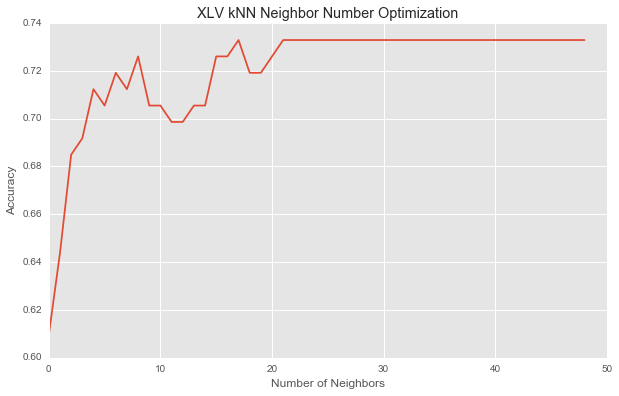

0.712328767123
[[  2  14   0]
 [  5 102   0]
 [  1  22   0]]


In [6]:
#Quick check for optimal nearest neighbors, on test and training

number=[]
for i in range(1,50):
    model = KNeighborsClassifier(n_neighbors = i)
    model.fit(XTrain, yTrain)
    y_pred=model.predict(XTest)
    number.append(metrics.accuracy_score(y_true = yTest, y_pred = y_pred))

plt.plot(number)
plt.title('XLV kNN Neighbor Number Optimization')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.savefig('graphs/XLV_Knn_1day_06.pdf')
plt.show()

#accuracy and confusion matrix for n nearest neighbors
model = KNeighborsClassifier(n_neighbors = 8)
model.fit(XTrain, yTrain)
y_pred=model.predict(XTest)
print(metrics.accuracy_score(y_true = yTest, y_pred = y_pred))
print(metrics.confusion_matrix(y_true = yTest, y_pred = y_pred))

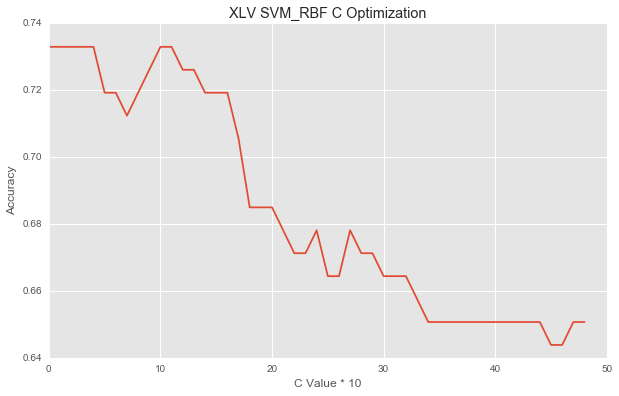

0.72602739726
[[  3  13   0]
 [  3 103   1]
 [  0  23   0]]


In [7]:
#Quick check for SVM, also prints accuracy and confusion matrix for n C parameter
number=[]
for i in range(1,50):
    model = svm.SVC(kernel='rbf',C=i/10)
    model.fit(XTrain, yTrain)
    y_pred=model.predict(XTest)
    number.append(metrics.accuracy_score(y_true = yTest, y_pred = y_pred))

plt.plot(number)
plt.title('XLV SVM_RBF C Optimization')
plt.xlabel('C Value * 10')
plt.ylabel('Accuracy')
plt.savefig('graphs/XLV_svm_1day_06.pdf')
plt.show()

model = svm.SVC(kernel='rbf',C=1.3)
model.fit(XTrain, yTrain)
y_pred=model.predict(XTest)
print(metrics.accuracy_score(y_true = yTest, y_pred = y_pred))
print(metrics.confusion_matrix(y_true = yTest, y_pred = y_pred))

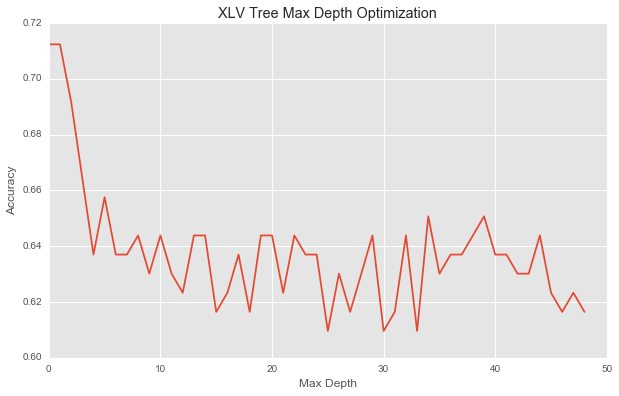

0.712328767123
[[ 2 13  1]
 [ 1 98  8]
 [ 2 17  4]]


In [8]:
#testing module for Decision Tree. Parameterized on depth. 
number=[]
for i in range(1,50):
    model = tree.DecisionTreeClassifier(max_depth=i)
    model.fit(XTrain, yTrain)
    y_pred=model.predict(XTest)
    number.append(metrics.accuracy_score(y_true = yTest, y_pred = y_pred))

plt.plot(number)
plt.title('XLV Tree Max Depth Optimization')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.savefig('graphs/XLV_tree_1day_06.pdf')
plt.show()

#accuracy and confusion matrix for n depth
model = tree.DecisionTreeClassifier(max_depth=2)
model.fit(XTrain, yTrain)
y_pred=model.predict(XTest)
print(metrics.accuracy_score(y_true = yTest, y_pred = y_pred))
print(metrics.confusion_matrix(y_true = yTest, y_pred = y_pred))

In [9]:
#Creates PCA from input data, calculates explained variance
pca_model = PCA()
X_PCA = pca_model.fit_transform(X)
var=pca_model.explained_variance_

# create a new pandas dataframe 
XP=pd.DataFrame(X_PCA)
XP.index.name=None

In [10]:
#KMeans clustering 
model=KMeans(n_clusters=20)
Xk=model.fit_predict(X)

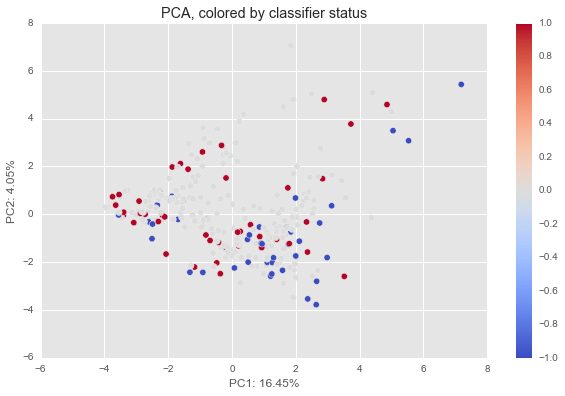

In [11]:
plt.scatter(XP[1],XP[2],c=y,cmap='coolwarm',s=40)
plt.xlabel('PC1: ' + str(var[0].round(decimals=2))+ '%')
plt.ylabel('PC2: ' + str(var[1].round(decimals=2))+ '%')
plt.colorbar()
plt.title('PCA, colored by classifier status')
#plt.savefig('PCA_by_classifier.pdf')
plt.show()

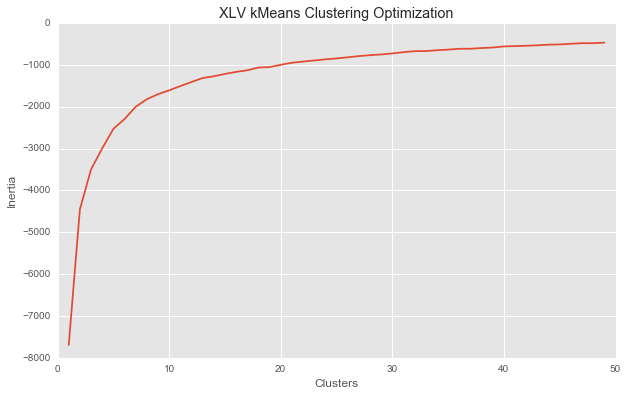

In [12]:
#rudimentary clustering analysis
ks=[]
scores=[]
for i in range(1,50):
    model = KMeans(n_clusters=i)
    model.fit_predict(X)
    scores.append(model.score(X))
    ks.append(i)

plt.plot(ks, scores)
plt.title('XLV kMeans Clustering Optimization')
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.savefig('org_data/XLV_kMeans')
plt.show()

In [13]:
#data correlations
X.corr()

,Price,7,50,200,bull_bear_msg_ratio,bull_minus_bear
Price,1.000000,0.955044,0.659830,-0.096481,-0.186766,0.215364
7,0.955044,1.000000,0.738453,-0.059450,-0.189631,0.152817
50,0.659830,0.738453,1.000000,0.264575,-0.135220,-0.033141
200,-0.096481,-0.059450,0.264575,1.000000,0.122805,-0.264078
bull_bear_msg_ratio,-0.186766,-0.189631,-0.135220,0.122805,1.000000,-0.259453
bull_minus_bear,0.215364,0.152817,-0.033141,-0.264078,-0.259453,1.000000


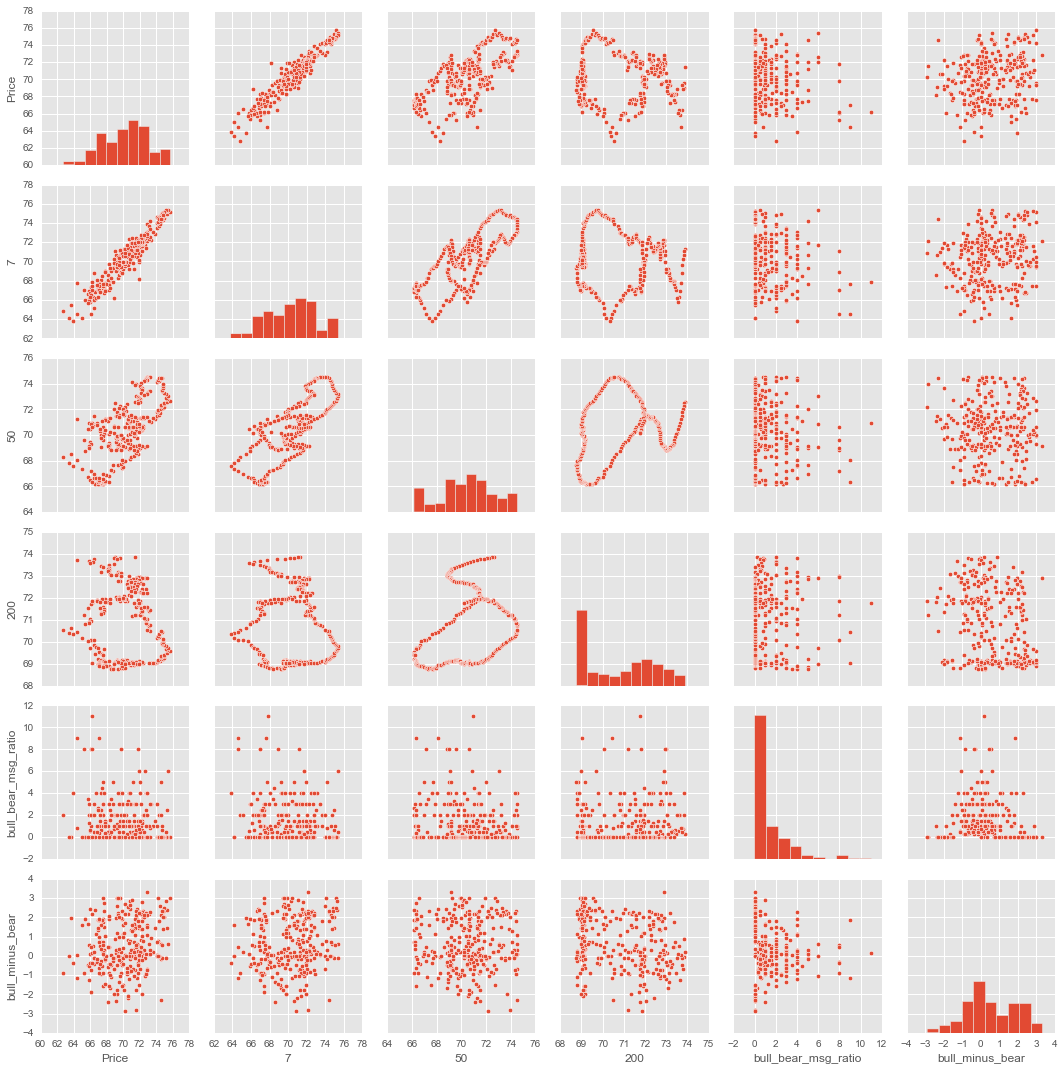

In [14]:
#plotted correlations
sns.pairplot(X);

Essential question: What model works the best of our models?
    - Does incorporating tweet data improve a model?
    - What technicals improve our predictive power?
    - Fun experiment: take today's values and predict direction. See what happens tomorrow.

In [7]:
#try.csv is a saved version of above data
alls=pd.read_csv('try.csv')
alls.index=alls['Unnamed: 0']
alls.index.name=None
y=alls['Move7']
del alls['Move7']
del alls['Unnamed: 0']
minus= alls[['Price','7','50','200','bull_bear_msg_ratio']]
ratio= alls[['Price','7','50','200','bull_minus_bear']]
sent=alls[['Price','7','50','200']]
averages=alls[['Price','bull_bear_msg_ratio','bull_minus_bear']]
price=pd.DataFrame(alls['Price'])
lists=[minus,ratio,sent,averages,price]

In [8]:
#make a module to test all three different modeling paradigms, and pick the max from each parameter space
score=[]
parameters=[]
for data in lists:
    test=[]
    val=[]
    XTrain, XTest, yTrain, yTest = train_test_split(data, y, test_size=0.5)
    number=[]
    for i in range(1,50):
        model = svm.SVC(kernel='rbf',C=i/10)
        model.fit(XTrain, yTrain)
        y_pred=model.predict(XTest)
        number.append(metrics.accuracy_score(y_true = yTest, y_pred = y_pred))
    test.append(max(number))
    val.append(np.argmax(number)+1)
    number=[]
    for i in range(4,50):
        model = KNeighborsClassifier(n_neighbors = i)
        model.fit(XTrain, yTrain)
        y_pred=model.predict(XTest)
        number.append(metrics.accuracy_score(y_true = yTest, y_pred = y_pred))
    test.append(max(number))
    val.append(np.argmax(number)+4)
    number=[]
    for i in range(4,50):
        model = tree.DecisionTreeClassifier(max_depth=i)
        model.fit(XTrain, yTrain)
        y_pred=model.predict(XTest)
        number.append(metrics.accuracy_score(y_true = yTest, y_pred = y_pred))
    test.append(max(number))
    val.append(np.argmax(number)+4)
    score.append(test)
    parameters.append(val)
    
#builds the results into a dataframe for plotting
scores=pd.DataFrame(score,columns=['svm','kNN','tree'],index=['minus','ratio','sent','averages','price'])
print(scores)
print(pd.DataFrame(parameters,columns=['svm(C)','kNN(k)','tree(max_depth)'],index=['minus','ratio','sent','averages','price']))

               svm       kNN      tree
minus     0.650685  0.664384  0.636986
ratio     0.726027  0.732877  0.575342
sent      0.719178  0.712329  0.643836
averages  0.691781  0.691781  0.534247
price     0.657534  0.657534  0.568493
          svm(C)  kNN(k)  tree(max_depth)
minus          1      15                4
ratio          1      36                6
sent          24      21                4
averages       1      45                5
price          5      13                4


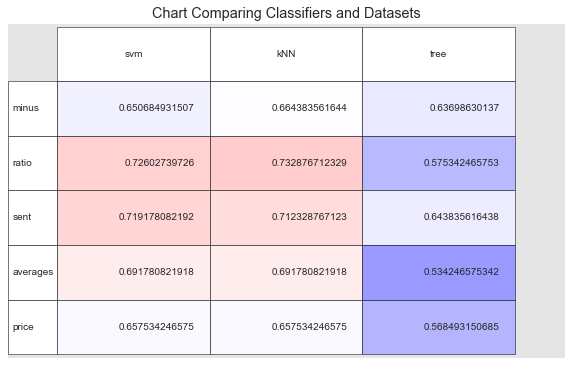

In [9]:
#plots the model tests on a table, colored by accuracy
vals=scores.values
cols=scores.columns
rows=scores.index
fig=plt.figure()
ax = fig.add_subplot(111)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
the_table = ax.table(cellText=vals,
          colLabels=cols, rowLabels=rows,
          loc='center',cellColours=plt.cm.seismic(vals*.75))
the_table.scale(.82, 4.55)
plt.title('Chart Comparing Classifiers and Datasets')
plt.savefig("XLV_model.pdf")
plt.show()

In [ ]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svr = svm.SVC()
clf = GridSearchCV(svr, parameters)
clf.fit(X, y)

In [ ]:
y_pred=clf.predict(minus)
print(metrics.accuracy_score(y_true = y, y_pred = y_pred))
clf.get_params()

In [31]:
#make a module to test all three different modeling paradigms, and pick the max from each parameter space
score=[]

for data in lists:
    test=[]
    XTrain, XTest, yTrain, yTest = train_test_split(data, y, train_size=0.4)
    
    parameters = {'kernel':('linear', 'rbf'), 'C':[.1, 10]}
    svr = svm.SVC()
    clf = GridSearchCV(svr, parameters,cv=5)
    clf.fit(XTrain, yTrain)
    y_pred=clf.predict(XTest)
    test.append(metrics.accuracy_score(y_true = yTest, y_pred = y_pred))
    
    parameters = {'n_neighbors':[1, 20]}
    kNN = KNeighborsClassifier()
    clf = GridSearchCV(kNN, parameters,cv=5)
    clf.fit(XTrain, yTrain)
    y_pred=clf.predict(XTest)
    test.append(metrics.accuracy_score(y_true = yTest, y_pred = y_pred))
   
    parameters = {'max_depth':[1, 20]}
    trees = tree.DecisionTreeClassifier()
    clf = GridSearchCV(trees, parameters,cv=5)
    clf.fit(XTrain, yTrain)
    y_pred=clf.predict(XTest)
    test.append(metrics.accuracy_score(y_true = yTest, y_pred = y_pred))
    
    score.append(test)
   
    
#builds the results into a dataframe for plotting
scores=pd.DataFrame(score,columns=['svm','kNN','tree'],index=['minus','ratio','sent','averages','price'])
print(scores)

               svm       kNN      tree
minus     0.761364  0.687500  0.687500
ratio     0.693182  0.670455  0.670455
sent      0.681818  0.647727  0.636364
averages  0.670455  0.659091  0.670455
price     0.670455  0.670455  0.664773


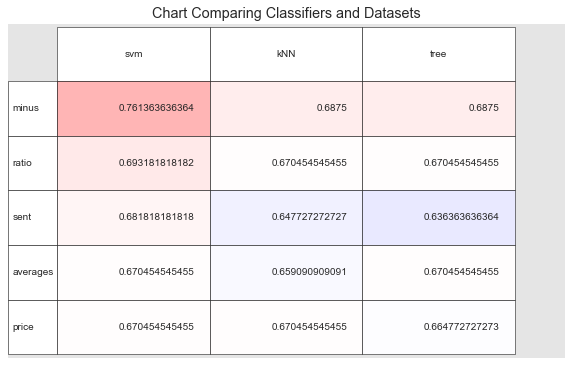

In [32]:
#plots the model tests on a table, colored by accuracy
vals=scores.values
cols=scores.columns
rows=scores.index
fig=plt.figure()
ax = fig.add_subplot(111)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
the_table = ax.table(cellText=vals,
          colLabels=cols, rowLabels=rows,
          loc='center',cellColours=plt.cm.seismic(vals*.75))
the_table.scale(.82, 4.55)
plt.title('Chart Comparing Classifiers and Datasets')
plt.savefig("XLV_model.pdf")
plt.show()